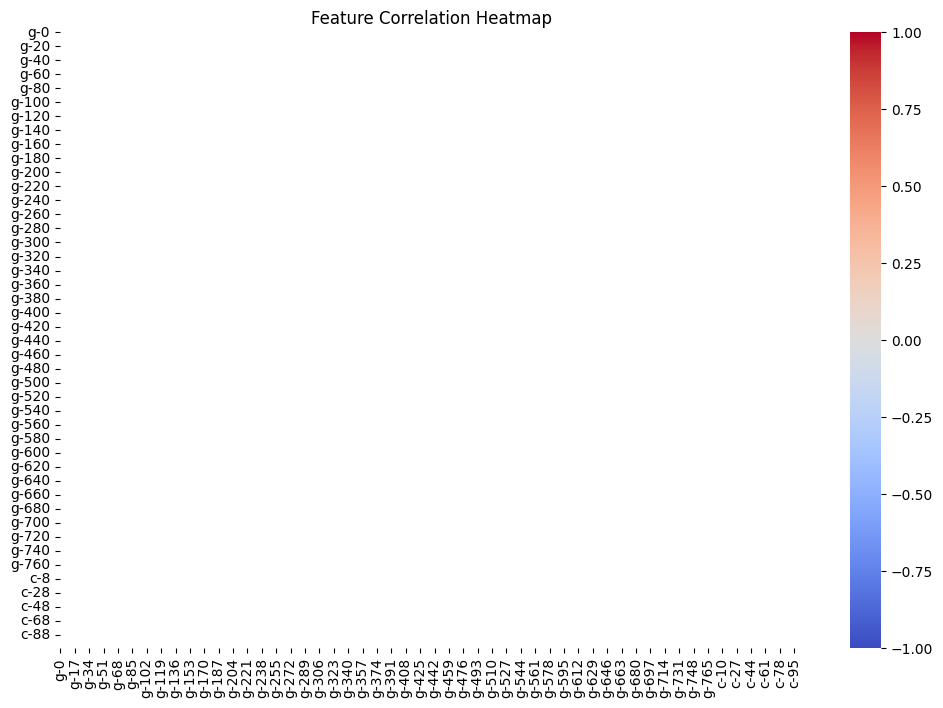

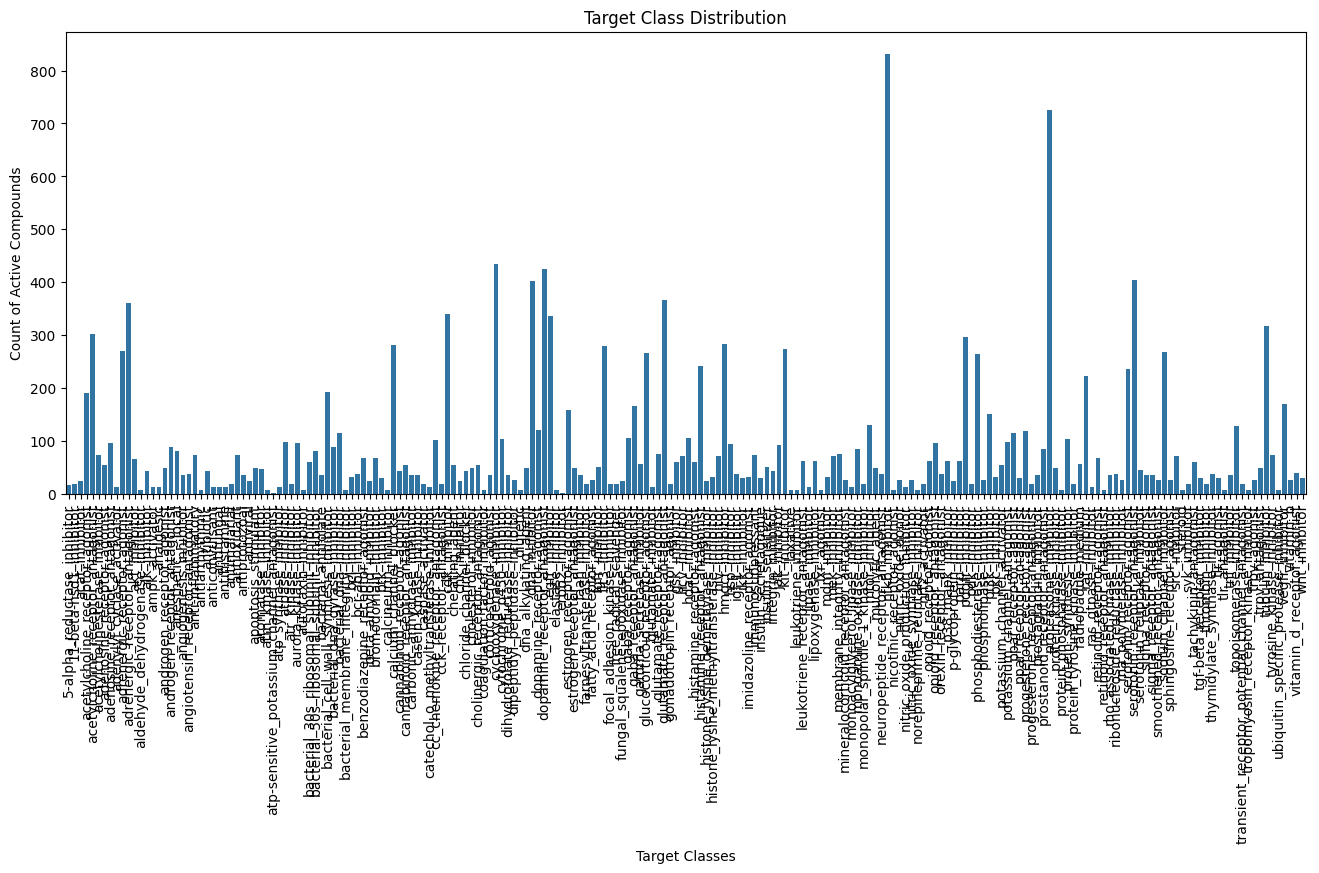

Validation Log Loss: 0.0216


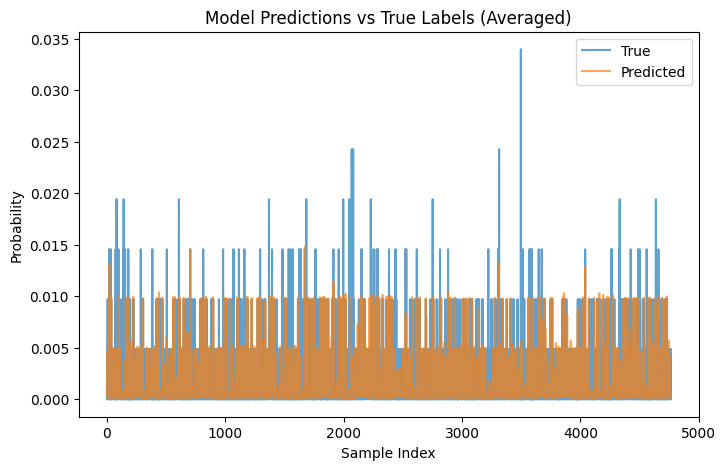

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive c

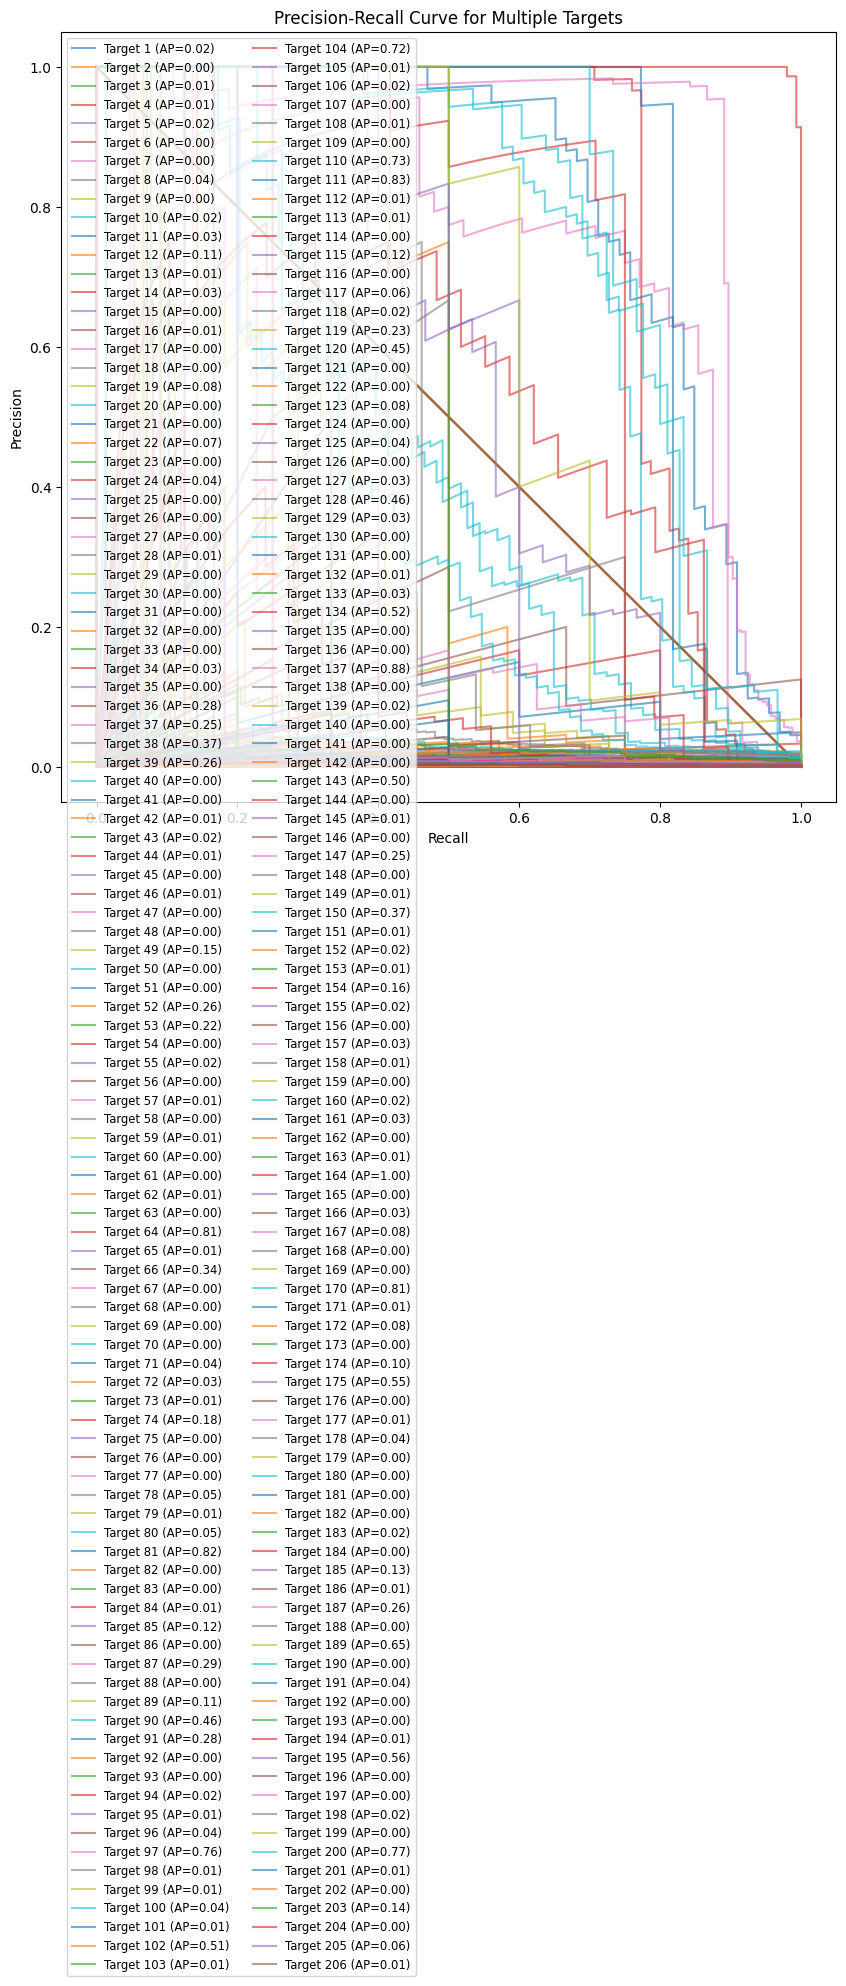

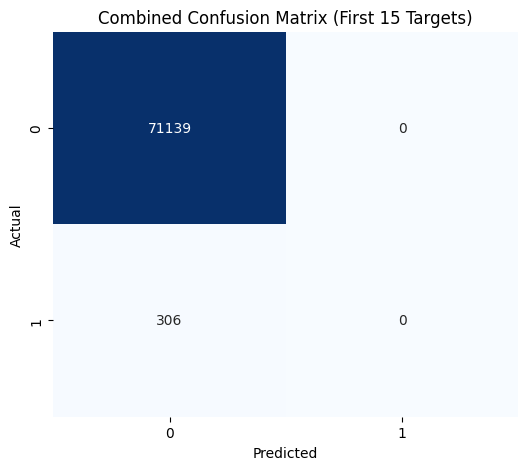

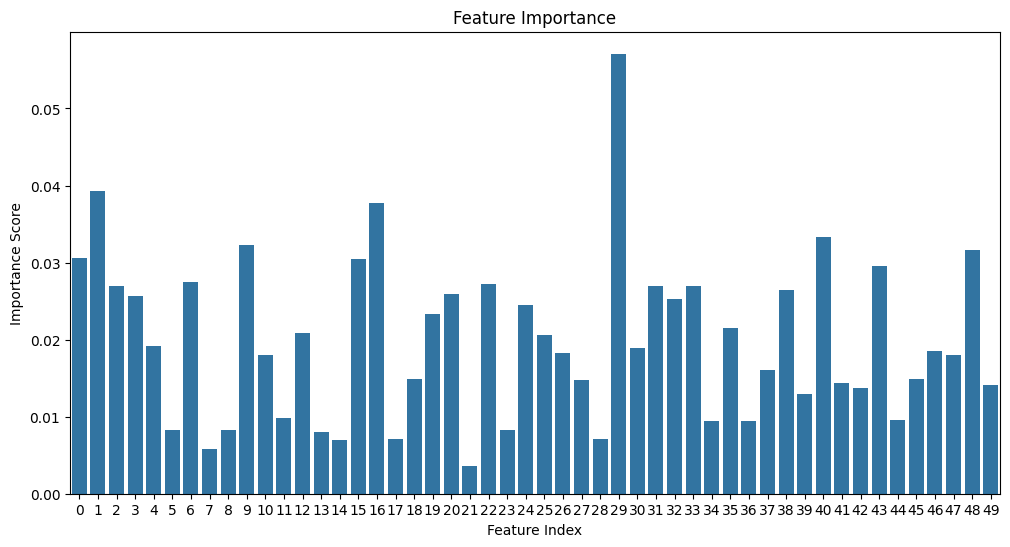

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import log_loss, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler



# Load data
data = pd.read_csv("train_features.csv")
targets = pd.read_csv("train_targets_scored.csv")

# Drop 'sig_id' and process categorical features
data = data.drop(columns=["sig_id"], errors="ignore")
categorical_cols = ["cp_type", "cp_time", "cp_dose"]
data[categorical_cols] = data[categorical_cols].fillna("missing")

# One-hot encode categorical features
data = pd.get_dummies(data, columns=categorical_cols)

# Standardize features
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Target Distribution
plt.figure(figsize=(16, 6))
target_sums = targets.iloc[:, 1:].sum(axis=0)
sns.barplot(x=target_sums.index, y=target_sums.values)
plt.xticks(rotation=90)
plt.title("Target Class Distribution")
plt.ylabel("Count of Active Compounds")
plt.xlabel("Target Classes")
plt.show()

# Ensure target columns are numeric
targets = targets.drop(columns=["sig_id"], errors="ignore").fillna(0)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    data, targets, test_size=0.2, random_state=42, stratify=targets.sum(axis=1)
)

# Dimensionality Reduction with PCA
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# XGBoost Model
xgb_model = XGBClassifier(
    max_depth=5,
    n_estimators=300,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# MultiOutput Classifier
multi_xgb_model = MultiOutputClassifier(xgb_model, n_jobs=-1)

# Fit model
multi_xgb_model.fit(X_train_pca, y_train)

# Predict probabilities
y_val_pred = multi_xgb_model.predict_proba(X_val_pca)

# Reshape predictions to 2D (206 targets)
y_val_pred = np.column_stack([pred[:, 1] for pred in y_val_pred])

# Calculate log loss
log_loss_score = log_loss(y_val.values.flatten(), y_val_pred.flatten())  # Flattened for proper input
print(f"Validation Log Loss: {log_loss_score:.4f}")

# Model Predictions vs True Labels (Averaged)
plt.figure(figsize=(8, 5))
plt.plot(range(len(y_val)), y_val.mean(axis=1), label='True', alpha=0.7)
plt.plot(range(len(y_val_pred)), y_val_pred.mean(axis=1), label='Predicted', alpha=0.7)
plt.legend()
plt.title("Model Predictions vs True Labels (Averaged)")
plt.xlabel("Sample Index")
plt.ylabel("Probability")
plt.show()

# Precision-Recall Curves
from sklearn.metrics import precision_recall_curve, average_precision_score

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 10))
for i in range(y_val.shape[1]):  # Iterate over all target columns
    precision, recall, _ = precision_recall_curve(y_val.iloc[:, i], y_val_pred[:, i])
    avg_precision = average_precision_score(y_val.iloc[:, i], y_val_pred[:, i])
    plt.plot(recall, precision, label=f'Target {i+1} (AP={avg_precision:.2f})', alpha=0.6)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Multiple Targets")
plt.legend(loc='best', fontsize='small', ncol=2)
plt.show()

# Combine First 15 Targets into One Confusion Matrix
y_true_bin = (y_val.iloc[:, :15] > 0.5).values.flatten()
y_pred_bin = (y_val_pred[:, :15] > 0.5).flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_bin, y_pred_bin)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Combined Confusion Matrix (First 15 Targets)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance Bar Chart
feature_importances = multi_xgb_model.estimators_[0].feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(x=np.arange(len(feature_importances)), y=feature_importances)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()
